### Feature Extraction Functions
Based on a two sources:
1. https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend
2. https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import librosa
from pathlib import Path
from tqdm import tqdm

# import kagglehub

In [ ]:
# # Download the GTZAN dataset from Kaggle
# path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")
# print("Path to dataset files:", path)

In [9]:
def split_audio(file_path):
    """
    split 30s fragment of WAV file into 3s frament.

    Parameters:
    - file_path (str): Path to the WAV audio file.

    Returns:
    - 3 second fragment of WAV file.
    """

    try:
        # Load the audio file
        y, sr = librosa.load(file_path, duration=30)  # Ensures consistency in duration
        features = {}
        # print(len(y)/sr)
        # Define the duration of each fragment (3 seconds)
        fragment_duration = 3  # seconds
        fragment_samples = fragment_duration * sr  # number of samples per fragment

        # Number of fragments
        num_fragments = len(y) // fragment_samples

        # Create a list to store the fragments
        fragments = []

        # Loop through the audio and create 3-second fragments
        for i in range(num_fragments):
            start_sample = i * fragment_samples
            end_sample = start_sample + fragment_samples
            frag = y[start_sample:end_sample]
            fragments.append(frag)

        return fragments, sr

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [10]:
def extract_audio_features(file_path, y, sr, label):
    """
    Extracts a comprehensive set of audio features from a WAV file.

    Parameters:
    - file_path (str): Path to the WAV audio file.
    - label (str): Genre label of the audio file.

    Returns:
    - features (dict): A dictionary containing the extracted audio features.
    """
    features = {}

    # Basic Metadata
    # print(os.path.basename(file_path))
    features['filename'] = os.path.basename(file_path)
    features['length'] = len(y)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        mfcc = mfccs[i-1]
        features[f'mfcc{i}_mean'] = np.mean(mfcc)
        features[f'mfcc{i}_var'] = np.var(mfcc)

    # Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_stft_mean'] = np.mean(chroma_stft)
    features['chroma_stft_var'] = np.var(chroma_stft)

    # RMS Energy
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = np.mean(rms)
    features['rms_var'] = np.var(rms)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_var'] = np.var(spectral_centroid)

    # Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_var'] = np.var(spectral_bandwidth)

    # Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_var'] = np.var(rolloff)

    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    features['zero_crossing_rate_mean'] = np.mean(zero_crossing_rate)
    features['zero_crossing_rate_var'] = np.var(zero_crossing_rate)

    # Harmony
    y_harmonic, _ = librosa.effects.hpss(y)
    harmony = librosa.feature.spectral_contrast(y=y_harmonic, sr=sr)
    features['harmony_mean'] = np.mean(harmony)
    features['harmony_var'] = np.var(harmony)

    # Percussive
    y_percussive, _ = librosa.effects.hpss(y)
    perceptr = librosa.feature.spectral_contrast(y=y_percussive, sr=sr)
    features['perceptr_mean'] = np.mean(perceptr)
    features['perceptr_var'] = np.var(perceptr)

    # Tempo
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    tempo = librosa.feature.rhythm.tempo(onset_envelope=onset_env, sr=sr)
    features['tempo'] = tempo[0]



    # Label
    features['label'] = label

    return features

In [4]:
def preprocess_audio_dataset(dataset_path, save_path):
    GENRES = [
        'blues', 
        'classical', 
        'country', 
        'disco', 
        'hiphop',
        'jazz',
        'metal', 
        'pop', 
        'reggae', 
        'rock'
    ]

    # Initialize a list to hold feature dictionaries
    features_list = []

    # Iterate through each genre and extract features from each file
    for genre in GENRES:
        genre_dir = Path(dataset_path) / genre
        if not genre_dir.exists():
            print(f"Genre directory {genre_dir} does not exist. Skipping...")
            continue

        # List all WAV files in the genre directory
        wav_files = list(genre_dir.glob('*.wav'))

        print(f"Processing genre: {genre} ({len(wav_files)} files)")
        for wav_file in tqdm(wav_files, desc=f"Processing {genre}"):
            # This file is broken, even when we downloaded the dataset from other sites.
            if str(wav_file) == "dataset/genres_original/jazz/jazz.00054.wav":
                continue
            fragment_list, sr= split_audio(str(wav_file))
            for idx, fragment in enumerate(fragment_list):
                # print(f"Processing fragment {idx}...")
                name = str(wav_file) + "_" + str(idx)
                feature_dict = extract_audio_features(name, fragment, sr, genre)
                if feature_dict:
                    features_list.append(feature_dict)

    # Create a DataFrame from the list of feature dictionaries
    df = pd.DataFrame(features_list)

    # Display the first few rows of the DataFrame
    print("Sample of extracted features:")
    print(df.head())

    # Save the DataFrame to a CSV file
    df.to_csv(save_path, index=False)
    print(f"Feature extraction complete. Saved to {save_path}")

In [39]:
preprocess_audio_dataset("dataset/genres_original", "dataset_extracted/features_3_sec_extracted.csv")

Processing genre: blues (100 files)


Processing blues: 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


Processing genre: classical (100 files)


Processing classical: 100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


Processing genre: country (100 files)


Processing country: 100%|██████████| 100/100 [03:36<00:00,  2.16s/it]


Processing genre: disco (100 files)


Processing disco: 100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


Processing genre: hiphop (100 files)


Processing hiphop: 100%|██████████| 100/100 [03:38<00:00,  2.19s/it]


Processing genre: jazz (100 files)


Processing jazz: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Processing genre: metal (100 files)


Processing metal: 100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


Processing genre: pop (100 files)


Processing pop: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Processing genre: reggae (100 files)


Processing reggae: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Processing genre: rock (100 files)


Processing rock: 100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


Sample of extracted features:
            filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav_0   66150          0.335555         0.090997  0.130189   
1  blues.00000.wav_1   66150          0.343523         0.086782  0.112119   
2  blues.00000.wav_2   66150          0.347746         0.092495  0.130895   
3  blues.00000.wav_3   66150          0.363863         0.087207  0.131349   
4  blues.00000.wav_4   66150          0.335481         0.088482  0.142370   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003559             1773.358004          169450.829707   
1  0.001491             1817.244034           90766.297514   
2  0.004552             1790.722358          110071.206762   
3  0.002338             1660.545231          109496.936309   
4  0.001734             1634.465076           77425.419156   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.334258           117272.640573  ...   39.54

In [22]:
split_audio("dataset/genres_original/jazz/jazz.00054.wav") # jazz.00054.wav is corrupted/broken

Error processing dataset/genres_original/jazz/jazz.00054.wav: 


/tmp/ipykernel_1053/249694234.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)  # Ensures consistency in duration
/home/hylke/miniconda3/envs/musicgenreclassification/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [3]:
print(f"Contents of the dataset at: {path}\n")

for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

Contents of the dataset at: /home/madojo/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1

1/
    Data/
        features_30_sec.csv
        features_3_sec.csv
        genres_original/
            metal/
                metal.00061.wav
                metal.00062.wav
                metal.00073.wav
                metal.00050.wav
                metal.00095.wav
                metal.00066.wav
                metal.00012.wav
                metal.00034.wav
                metal.00037.wav
                metal.00094.wav
                metal.00055.wav
                metal.00057.wav
                metal.00007.wav
                metal.00031.wav
                metal.00081.wav
                metal.00093.wav
                metal.00020.wav
                metal.00077.wav
                metal.00004.wav
                metal.00092.wav
                metal.00021.wav
                metal.00052.wav
                metal.00045.wav
                m

Text(0.5, 1.0, 'Waveform Track: Classical')

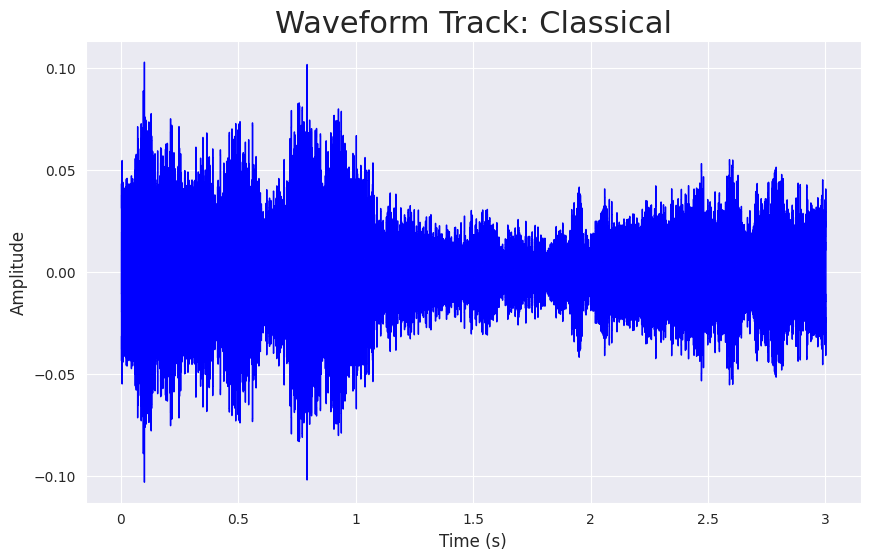

In [12]:

classical_dir = Path('dataset/genres_original/classical')
hiphop_dir = Path('dataset/genres_original/hiphop')

wav_files_classical = list(classical_dir.glob('*.wav'))
wav_files_hiphop = list(hiphop_dir.glob('*.wav'))

track_classical = wav_files_classical[0]
fragment_list_classical, sr= split_audio(str(track_classical))
fragment_classical = fragment_list_classical[0]

track_hiphop = wav_files_hiphop[0]
fragment_list_hiphop, sr= split_audio(str(track_hiphop))
fragment_hiphop = fragment_list_hiphop[0]

plt.figure(figsize = (10, 6))
librosa.display.waveshow(y = fragment_classical, sr = sr, color = 'blue')
plt.ylabel("Amplitude", fontsize = 12)
plt.xlabel("Time (s)", fontsize = 12)
plt.title("Waveform Track: Classical", fontsize = 22)


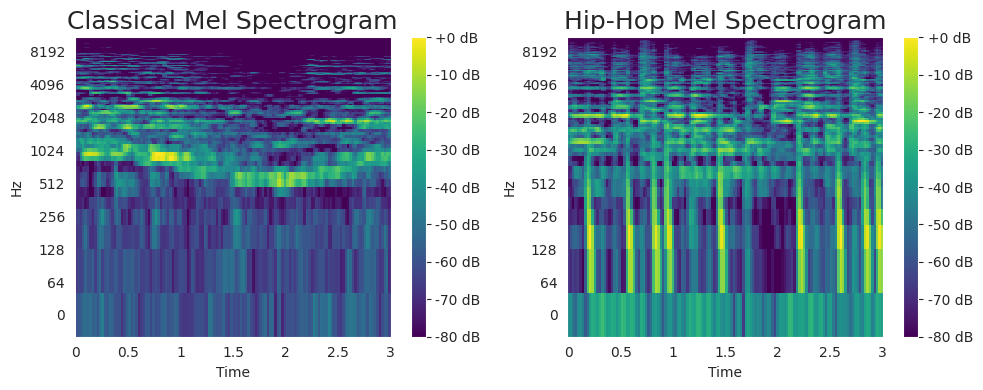

In [13]:
# Process for fragment_classical
fragment_classical, _ = librosa.effects.trim(fragment_classical)
S_classical = librosa.feature.melspectrogram(y=fragment_classical, sr=sr)
S_DB_classical = librosa.amplitude_to_db(S_classical, ref=np.max)

# Process for fragment_hiphop
fragment_hiphop, _ = librosa.effects.trim(fragment_hiphop)
S_hiphop = librosa.feature.melspectrogram(y=fragment_hiphop, sr=sr)
S_DB_hiphop = librosa.amplitude_to_db(S_hiphop, ref=np.max)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot for classical fragment
cax1 = librosa.display.specshow(S_DB_classical, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='viridis', ax=ax[0])
ax[0].set_title("Classical Mel Spectrogram", fontsize=18)
# Add colorbar for classical
fig.colorbar(cax1, ax=ax[0], format="%+2.0f dB")

# Plot for hip-hop fragment
cax2 = librosa.display.specshow(S_DB_hiphop, sr=sr, hop_length=512, x_axis='time', y_axis='log', cmap='viridis', ax=ax[1])
ax[1].set_title("Hip-Hop Mel Spectrogram", fontsize=18)
# Add colorbar for hip-hop
fig.colorbar(cax2, ax=ax[1], format="%+2.0f dB")

# Adjust layout
plt.tight_layout()
plt.show()